# Topics Based on Country 2015

I have also decided to see, if there are some topics more representitive for different universities invloved with the program. In order to do so, I have analized the abstracts of 2015 based on the university it came from. Down in the results of the popularity of each topic based on the country of the person participating. 

In [1]:
# importing the libaries
from constants import all_topics_names 
import matplotlib.pyplot as plt
import subprocess
import collections
import pandas
import nltk
import scipy
import os

In [2]:
# importing the topics of each abstract
topic_data = pandas.read_csv("sata.csv", sep="\t")

In [3]:
# clean the pandas
topic_data.columns = ["Index"] + [column_name for column_name in all_topics_names.values()] + ["Filename", "Title"]
del topic_data["Index"]

In [4]:
# get abstract titles from the data
all_abstract_titles = [(filename.split("_")[1], filename.split("_")[2].split(".")[0], title)for filename, title in zip(topic_data["Filename"], topic_data["Title"])]

In [5]:
# doanload links for proceedings (link, starting page, ending page, year)
links = [("https://www.unet.univie.ac.at/~a9825248/MEiCogSci_Conference_Proceedings_2015.pdf", 28, 79, 2015),
         ("https://www.unet.univie.ac.at/~a9825248/MEiCogSci_Conference_Proceedings_2015.pdf", 82, 142, 2015)]

In [6]:
# countries involved
countries = ["Austria", "Slovenia", "Slovakia", "Croatia", "Hungary", "Germany", "Finland", "Romania", "Poland"
            "Slovenija", "Poland", "Slovenija"]

In [7]:
# universities involved
all_universities = ["University of Vienna, Vienna, Austria", 
                    "University of Ljubljana, Ljubljana, Slovenia", 
                    "Comenius University, Bratislava, Slovakia",
                    "University of Zagreb, Zagreb, Croatia",
                    "Central European University, Budapest, Hungary", 
                    "Max Planck Institut for Human Development, Berlin, Germany", 
                    "University of Jyväskylä, Jyväskylä, Finland", 
                    "University of Bucharest, Bucharest, Romania", 
                    "Jagiellonian University, Kraków, Poland",
                    "University of Applied Sciences bfi, Vienna, Austria",
                    "Austria Medical University of Vienna, Vienna, Austria", 
                    "Wolf Science Center, Ernstbrunn, Austria",
                    "University of Veterinary Medicine, Vienna, Austria",
                    "Pontifical University of John Paul II, Kraków, Poland",
                    "University Medical Centre Ljubljana, Ljubljana, Slovenia"
                   ]

In [8]:
# change the names of universities
change_names = dict([("Pedagoška University, Ljubljana, Slovenia", "University of Ljubljana, Ljubljana, Slovenia"), 
                     ("Comenius University. Bratislava, Slovakia", "Comenius University, Bratislava, Slovakia"), 
                     ("Comenius University in Bratislava, Bratislava, Slovakia", "Comenius University, Bratislava, Slovakia"),
                     ("University of Ljubljana, Ljubljana, Slovenija", "University of Ljubljana, Ljubljana, Slovenia"), 
                     ("University in Ljubljana, Ljubljana, Slovenia", "University of Ljubljana, Ljubljana, Slovenia"), 
                     ("Max Planck Institute for Human Development, Berlin, Germany", "Max Planck Institut for Human Development, Berlin, Germany")])

In [9]:
# parse the proceedings to get university name and title out of it
articles_with_university_names = []
for link, start, end, year in links:
    filename = link.split("/")[-1]
    if not os.path.isfile(filename):
        subprocess.run(["wget", filename])
    for i in range(start, end+1):
        subprocess.run(["pdftotext", "-f", str(i), "-l", str(i), filename, "current.txt"])
        with open("current.txt") as f:
            current_data = f.readlines()
        last_index = 0
        for j, line in enumerate(current_data):
            for country in countries:
                if country in line and last_index == 0 and "MEi:CogSci Conference 2015, Ljubljana, Slovenia Posters" not in line:
                    last_index = j
        university_name = " ".join(current_data[:last_index+1][-2:]).replace("\n", "")
        rest_of_data = " ".join(current_data[:last_index+1][:-2])
        word_tok = nltk.word_tokenize(rest_of_data)
        if "," in word_tok:
            if word_tok.index(",") > 3:
                title = word_tok[:word_tok.index(",") - 2]
            elif word_tok.index(",") <= 3 and "," in word_tok[3:]:
                title = word_tok[:word_tok[3:].index(",") - 2]
            else:
                title = word_tok[:-2]
        else:
            title = word_tok[:-2]
        articles_with_university_names.append([university_name, title, year])

In [10]:
# compate the title in abstracts in procedings and find the most similar one
id_with_university = []
for abstract_year, abstract_id, abstract_title in all_abstract_titles:
    abstract_title = nltk.word_tokenize(abstract_title)
    similarity_data = []
    for university, proc_title, proc_year in articles_with_university_names:
        if int(proc_year) == int(abstract_year):
            proc_title_num = []
            abstract_title_num = []
            all_words = list(set(proc_title + abstract_title))
            for word in all_words:
                if word in proc_title:
                    proc_title_num.append(1)
                else:
                    proc_title_num.append(0)
                if word in abstract_title:
                    abstract_title_num.append(1)
                else:
                    abstract_title_num.append(0)
            dist = scipy.spatial.distance.cosine(proc_title_num, abstract_title_num)
            similarity_data.append([proc_year, abstract_id, abstract_title, proc_title, dist, university])
    if similarity_data:
        most_similar = pandas.DataFrame(similarity_data).sort_values(4).head(1)
        most_similar = [list(row[1]) for row in most_similar.iterrows()][0]
        id_with_university.append([most_similar[1], most_similar[5]])

In [11]:
# make magic on dataframes and create the dataframe, that connects all the data
id_with_country = [(i, uni.split(",")[-1].strip()) for i, uni in id_with_university if uni.split(",")[-1].strip()]
id_with_country_pandas = pandas.DataFrame(id_with_country, columns=["ID", "Country"])
topic_data["ID"] = [filename.split("_")[-1].split(".")[0] for filename in topic_data["Filename"]]
combined_pandas = pandas.merge(topic_data, id_with_country_pandas, on="ID", how="inner")

In [12]:
# correct misspelled countries
correct_countries = {'Slovenija': 'Slovenia'}

In [13]:
# create the data for each country
countries_abstracts = collections.defaultdict(int)
countries_with_topics = collections.defaultdict(dict)
for row, data in combined_pandas.iterrows():
    if data["Country"] in correct_countries:
        data["Country"] = correct_countries[data["Country"]]
    countries_abstracts[data["Country"]] += 1
    for topic in data.index[:-4]:
        if not topic in countries_with_topics[data["Country"]]:
            countries_with_topics[data["Country"]][topic] = 0
        countries_with_topics[data["Country"]][topic] += data[topic]

In [14]:
# how many abstracts came from each country
countries_abstracts

defaultdict(int,
            {'Slovakia': 24,
             'Austria': 36,
             'Slovenia': 39,
             'Poland': 6,
             'Croatia': 1,
             'Romania': 1,
             'Germany': 2,
             'Hungary': 1})

In [15]:
# normalize the data
countries_with_topics_corr = dict()
for country, topics in countries_with_topics.items():
    countries_with_topics_corr[country] = dict()
    for topic, value in topics.items():
        countries_with_topics_corr[country][topic] = value/countries_abstracts[country]

In [16]:
# change the data to dataframe
plot_data = pandas.DataFrame(countries_with_topics_corr)

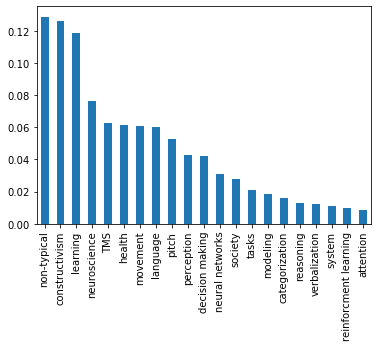

In [17]:
# plot for Slovenia
plot_data["Slovenia"].sort_values(ascending=False).plot(kind="bar")

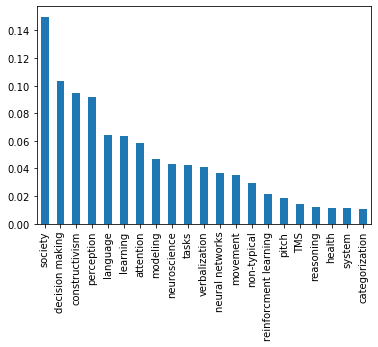

In [18]:
# plot for Austria
plot_data["Austria"].sort_values(ascending=False).plot(kind="bar")

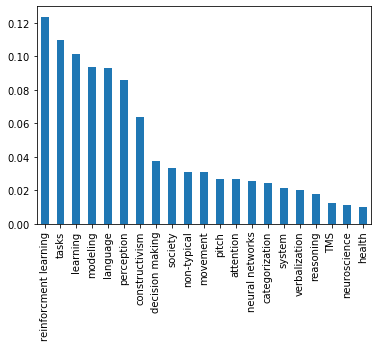

In [19]:
# Plot for Slovakia
plot_data["Slovakia"].sort_values(ascending=False).plot(kind="bar")